# Gaussian Process Regressor 

## Import libraries

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

# import sklearn method for preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt  

# import uncertainty toolbox to compute and plot metrics
import uncertainty_toolbox as uct

# import the gaussian process from scikit-learn 
import sklearn.gaussian_process as gp

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

2022-08-24 00:37:37.931031: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-24 00:37:37.936607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 00:37:37.936619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and Preprocess data

In [2]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)
#Split data into training and testing sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Training Data : (8817, 753)
Testing Data  : (980, 753)



## Model 

In [3]:
#Lets define the kernel (RBF) ie the covariance matrix 
KERNEL = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

#Define the model
model = gp.GaussianProcessRegressor(kernel = KERNEL,
                                    n_restarts_optimizer = 10,
                                    alpha = 0.1,
                                    normalize_y = True)

In [4]:
%%time
model.fit(X_train, y_train)
params = model.kernel_.get_params()

CPU times: user 9h 46min 38s, sys: 1h 16min 37s, total: 11h 3min 15s
Wall time: 3h 53min 48s


In [5]:
y_pred, std = model.predict(X_test, return_std=True)

In [6]:
y_pred_train, std_train = model.predict(X_train, return_std=True)

In [7]:
residusGP = y_test-y_pred

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

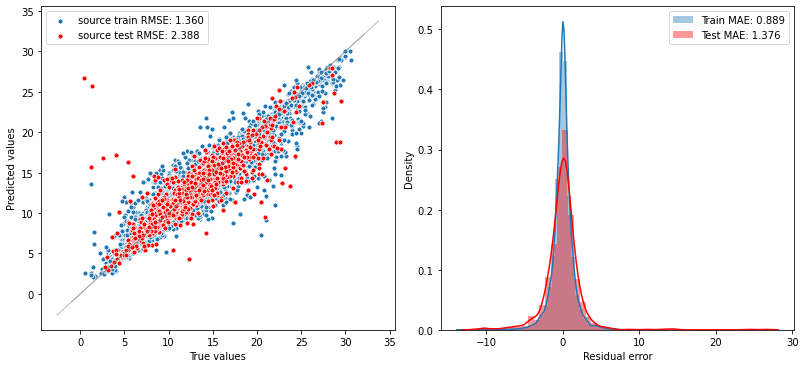

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]);ax2 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, np.array(y_pred_train), label='source train',  ax=ax1, score='RMSE')
plot_adequation(y_test,np.array(y_pred), label='source test', ax=ax1,score='RMSE', color='red')
ax1.grid(False)
plot_residuals(y_train, np.array(y_pred_train), kind='hist', label='Train', ax=ax2, score='MAE')
plot_residuals(y_test, np.array(y_pred), kind='hist', label='Test', ax=ax2, score='MAE', color ='red')
ax2.grid(False)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

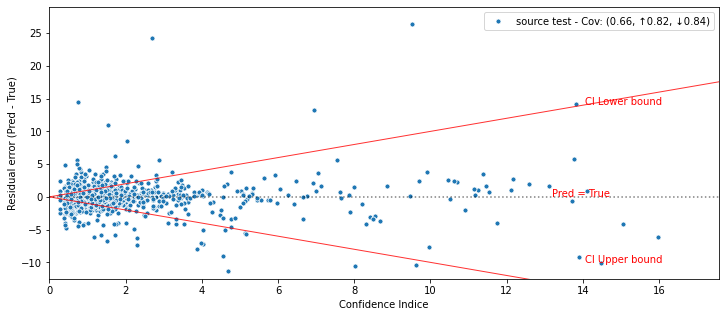

In [9]:
plot_confidence_v2(y_test,y_pred , y_pred-2*std,  y_pred+2*std, label='source test')

In [10]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(y_pred),  np.array(std), np.array(y_test), criterion='ma_cal')

In [11]:
new_stds = recalibrator(std)

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

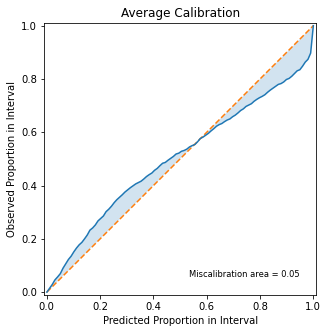

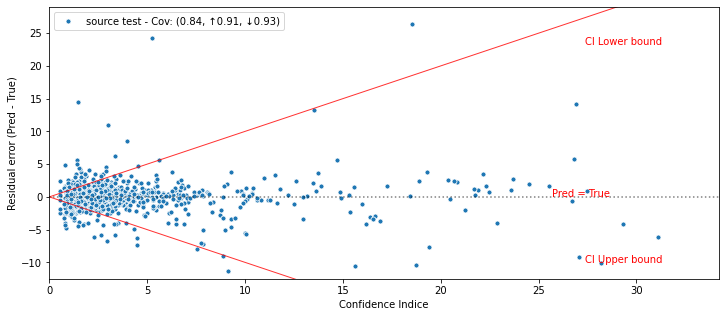

In [12]:
uct.viz.plot_calibration(np.array(y_pred),  np.array(new_stds) , np.array(y_test))
plot_confidence_v2(y_test,np.array(y_pred) , np.array(y_pred)-2*new_stds, np.array(y_pred)+2*new_stds, label='source test')

In [13]:
metrics = uct.metrics.get_all_metrics(np.array(y_pred), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.376
  RMSE          2.388
  MDAE          0.840
  MARPD         10.929
  R2            0.722
  Correlation   0.850
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.063
  Mean-absolute Calibration Error       0.054
  Miscalibration Area                   0.055
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.086
     Group Size: 0.56 -- Calibration Error: 0.062
     Group Size: 1.00 -- Calibration Error: 0.054
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.104
     Group Size: 0.56 -- Calibration Error: 0.070
     Group Size: 1.00 -- Calibration Error: 0.063
===============

### Save metrics

In [14]:
import pickle

In [15]:
with open('GPR_metrics_sparse.pkl', 'wb') as f:
    pickle.dump(metrics, f)